In [46]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
# from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import joblib
from sklearn.utils.class_weight import compute_sample_weight
from datetime import datetime
from xgboost import XGBClassifier

In [47]:
# import clickhouse_connect
# DATABASE_NAME = 'binance_data_indicator' 
# # OHLC_1M = 'trx_1m_ohlc'  # Changed from btc to trx
# # # INDICATOR_1M = 'trx_1m_indicator'  # Changed from btc to trx

# TABLE1_NAME = 'ethusdt_1m_extended'  # Changed table's name
# TABLE2_NAME = 'ethusdt_1m_forward_ohlc'  # Changed table's name

# # CLICKHOUSE_HOST = 'localhost' # Get qua Docker
# CLICKHOUSE_HOST = '117.0.34.78'
# CLICKHOUSE_PORT = 8123
# CLICKHOUSE_USER = 'looker'
# CLICKHOUSE_PASSWORD = ''

# clickhouse_client = clickhouse_connect.get_client(host=CLICKHOUSE_HOST, port=CLICKHOUSE_PORT, username=CLICKHOUSE_USER, password=CLICKHOUSE_PASSWORD)

# # sql = f'''
# #     SELECT * FROM {DATABASE_NAME}.{INDICATOR_1M} FINAL
# #     WHERE OpenTime >= '2024-12-01 00:00:00'
# #     ORDER BY OpenTime DESC
# #     LIMIT 400000
# # '''

# sql = f'''
#     SELECT
#     a.OpenTime,
#     a.MinuteId AS MinuteId,
#     a.Close AS Close,
#     a.* EXCEPT(OpenTime, Close, MinuteId),
#     b.* EXCEPT(OpenTime, Close, MinuteId, StartCumulative)
#     FROM
#     (SELECT * FROM {DATABASE_NAME}.{TABLE1_NAME} FINAL) AS a
#     JOIN
#     (SELECT * FROM {DATABASE_NAME}.{TABLE2_NAME} FINAL) AS b
#     ON
#     a.OpenTime = b.OpenTime
#     WHERE
#     a.Valid = '1'
#     ORDER BY
#     a.OpenTime DESC
# '''
# # Đọc dữ liệu
# # df = clickhouse_client.query_df(sql)
# df = clickhouse_client.query_df(sql, settings={'max_result_rows': 500000})

# # Chuyển đổi OpenTime thành datetime
# df['OpenTime'] = pd.to_datetime(df['OpenTime'])

# df.set_index('OpenTime', inplace=True)

# # df[['Close','Low','High','min_low_5', 'min_low_10', 'max_high_5', 'max_high_10', 'min_low_30', 'max_high_30','close_vs_minlow5_pct', 'close_vs_minlow10_pct', 'close_vs_minlow30_pct']].head(30)
# # df[['OpenTime', 'macd_diff', 'sma_macd_diff_5','sma_macd_diff_10','sma_macd_diff_sub']].head(20)

In [48]:
import os

# Đường dẫn
# data_path = 'F:/dataML/data/TRX/TRX_2025-06-13_03-54-57.csv'
data_path = 'F:/dataML/data/TRX/output/TRX_18_26555370_20200628_061900_223181.csv'

# Tên dataset
dataset_name = os.path.splitext(os.path.basename(data_path))[0]

# Lấy ngày hiện tại theo định dạng YYYY-MM-DD
today_str = datetime.today().strftime('%Y-%m-%d')

# Đọc dữ liệu
df = pd.read_csv(data_path)

# Chuyển đổi OpenTime thành datetime
df['OpenTime'] = pd.to_datetime(df['OpenTime'])

df.set_index('OpenTime', inplace=True)

# df[['Close','Low','High','min_low5', 'min_low10', 'max_high5', 'max_high10', 'min_low30', 'max_high30','close_vs_minlow5_pct', 'close_vs_minlow10_pct', 'close_vs_minlow30_pct']].head(30)


In [49]:
Y_TYPE = 'close_vs_minlow60_r8'

# Đếm số lượng bản ghi
count_rows = len(df)

# Đếm số lượng 0
count_zeros = (df[Y_TYPE] == 0).sum().sum()

# Đếm số lượng 1
count_ones = (df[Y_TYPE] == 1).sum().sum()

# In kết quả
print("Số lượng giá trị 0:", count_zeros)
print("Số lượng giá trị 1:", count_ones)
print("Số lượng bản ghi:", count_rows) 

Số lượng giá trị 0: 29281
Số lượng giá trị 1: 193900
Số lượng bản ghi: 223181


TRỰC QUAN HÓA % CỦA GIÁ "CLOSE" VỚI MIN LOW VÀ MIN HIGH

In [50]:
# label_cols = [
#     'close_vs_minlow5_r8',
#     'close_vs_minlow10_r8',
#     'close_vs_minlow30_r8',
#     'close_vs_minlow60_r8',
#     'close_vs_maxhigh5_r8',
#     'close_vs_maxhigh10_r8',
#     'close_vs_maxhigh30_r8',
#     'close_vs_maxhigh60_r8'
# ]

# # Điều chỉnh kích thước figure 
# plt.figure(figsize=(15, 8))

# for i, col in enumerate(label_cols):
#     plt.subplot(2, 4, i + 1)  
#     sns.countplot(data=df, x=col, hue=col, palette='pastel', legend=False)
#     plt.title(f'Class balance: {col}')
#     plt.xlabel('Label')
#     plt.ylabel('Count')

# plt.tight_layout()
# plt.show()


In [51]:
df.isna().sum()

MinuteId                   0
Close                      0
StartCumulative            0
delta                      0
gain                       0
                          ..
close_vs_minlow60_r20      0
close_vs_maxhigh60_pct    60
close_vs_maxhigh60_r8      0
close_vs_maxhigh60_r10     0
close_vs_maxhigh60_r20     0
Length: 66, dtype: int64

CHIA DỮ LIỆU 70% TRAIN, 20% VALIDATION, 10% TEST

In [52]:
features = [
    'sma_macd_diff_5',
    'sma_macd_diff_10', 
    'sma_macd_diff_sub',
    'macd_diff',
    'macd',
    'rsi_14'
]

X = df[features]
y = df[Y_TYPE]

# Chia dữ liệu: 70% train, 30% test
# Bước 1: Chia 30% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=True
)

# # Bước 2: Chia 90% còn lại thành 77.8% train và 22.2% validation 
# # (tương đương 70% và 20% của toàn bộ dữ liệu)
# X_train, X_val, y_train, y_val = train_test_split(
#     X_temp, y_temp, test_size=0.2222, random_state=42, shuffle=True
# )


In [53]:
# Kiểm tra tỷ lệ nhãn 0 và 1 trong y_train
import numpy as np
import pandas as pd

label_counts = pd.Series(y_train).value_counts()
label_percent = label_counts / label_counts.sum() * 100

print("Số lượng mỗi nhãn trong tập train:")
print(label_counts)

print("\nTỷ lệ phần trăm mỗi nhãn trong tập train:")
print(label_percent.round(2))


Số lượng mỗi nhãn trong tập train:
close_vs_minlow60_r8
1    135792
0     20434
Name: count, dtype: int64

Tỷ lệ phần trăm mỗi nhãn trong tập train:
close_vs_minlow60_r8
1    86.92
0    13.08
Name: count, dtype: float64


GRADIENT BOOST PARAMS

In [54]:
# Tính toán scale_pos_weight để xử lý imbalanced data
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Scale pos weight: {scale_pos_weight:.2f}")

# Khởi tạo mô hình XGBoost
xgb_model = XGBClassifier(
    n_estimators=250,           # Số lượng cây
    learning_rate=0.05,         # Tốc độ học
    max_depth=6,                # Độ sâu tối đa của cây
    min_child_weight=10,        # Trọng số tối thiểu của child node
    subsample=0.8,              # Tỷ lệ mẫu cho mỗi cây
    colsample_bytree=0.8,       # Tỷ lệ features cho mỗi cây
    reg_alpha=0.1,              # L1 regularization
    reg_lambda=1.0,             # L2 regularization
    scale_pos_weight=scale_pos_weight,  # Xử lý imbalanced data
    random_state=42,
    eval_metric='logloss',      # Metric để đánh giá
    verbosity=0
)

xgb_model.fit(X_train, y_train)
# # Giả sử model của bạn là `model` và muốn lưu với tên theo `Y_TYPE`
# model_path = f'F:/dataML/models/GradientBoosting/{dataset_name}/{today_str}/minlow/GB_{Y_TYPE}.joblib'
# os.makedirs(f"F:/dataML/models/GradientBoosting/{dataset_name}/{today_str}/minlow", exist_ok=True)
# joblib.dump(gb_model, model_path)

Scale pos weight: 0.15


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, ...)

ĐÁNH GIÁ ĐỘ CHÍNH XÁC

In [55]:
# Dự đoán và tính độ chính xác
y_pred_xgb = xgb_model.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"Độ chính xác của mô hình XGBoost: {accuracy_xgb * 100:.2f}%")

# Lấy báo cáo phân loại dưới dạng dict
report = classification_report(y_test, y_pred_xgb, output_dict=True)

# In báo cáo dạng phần trăm 
print("\nBáo cáo phân loại (%):")
print(f"{'Label':<12} {'Precision':>12} {'Recall':>12} {'F1-score':>12} {'Support':>10}")

def format_percent(value):
    return f"{value * 100:.2f}%"

for label, metrics in report.items():
    if isinstance(metrics, dict):
        print(f"{label:<12} {format_percent(metrics['precision']):>12} {format_percent(metrics['recall']):>12} {format_percent(metrics['f1-score']):>12} {int(metrics['support']):>10}")
    elif label == "accuracy":
        print(f"{label:<12} {'-':>12} {'-':>12} {format_percent(metrics):>12} {int(report['macro avg']['support']):>10}")


Độ chính xác của mô hình XGBoost: 56.18%

Báo cáo phân loại (%):
Label           Precision       Recall     F1-score    Support
0                  17.76%       63.80%       27.79%       8847
1                  90.89%       55.03%       68.55%      58108
accuracy                -            -       56.18%      66955
macro avg          54.33%       59.41%       48.17%      66955
weighted avg       81.23%       56.18%       63.16%      66955


In [56]:
print("Train accuracy:", xgb_model.score(X_train, y_train))
print("Test accuracy:", xgb_model.score(X_test, y_test))

Train accuracy: 0.575147542662553
Test accuracy: 0.5618400418191323


KẾT QUẢ

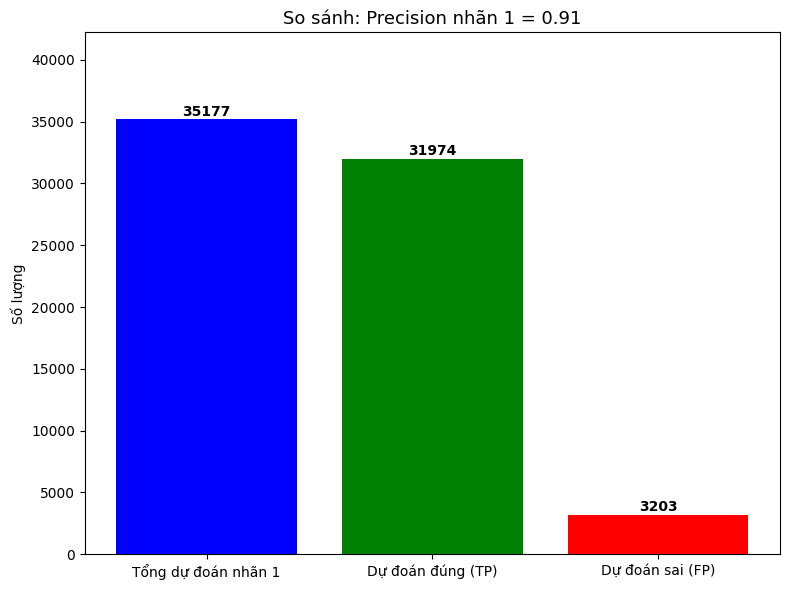

In [ ]:
# Tính TP, FP cho nhãn 1
tp_1 = np.sum((y_test == 1) & (y_pred_xgb == 1))  # True Positive
fp_1 = np.sum((y_test == 0) & (y_pred_xgb == 1))  # False Positive
total_predicted_1 = tp_1 + fp_1  # Tổng số lần mô hình dự đoán là nhãn 1

# Precision cho nhãn 1
precision_1 = tp_1 / total_predicted_1 if total_predicted_1 > 0 else 0

# Dữ liệu biểu đồ
labels = ['Tổng dự đoán nhãn 1', 'Dự đoán đúng (TP)', 'Dự đoán sai (FP)']
values = [total_predicted_1, tp_1, fp_1]
colors = ['blue', 'green', 'red']

# Vẽ biểu đồ
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, values, color=colors)

# Thêm số liệu trên đầu cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50, f'{int(yval)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Tiêu đề biểu đồ
plt.title(f'So sánh: Precision nhãn 1 = {precision_1:.2f}', fontsize=13)
plt.ylabel('Số lượng')
plt.ylim(0, max(values) * 1.2)
plt.tight_layout()
plt.show()


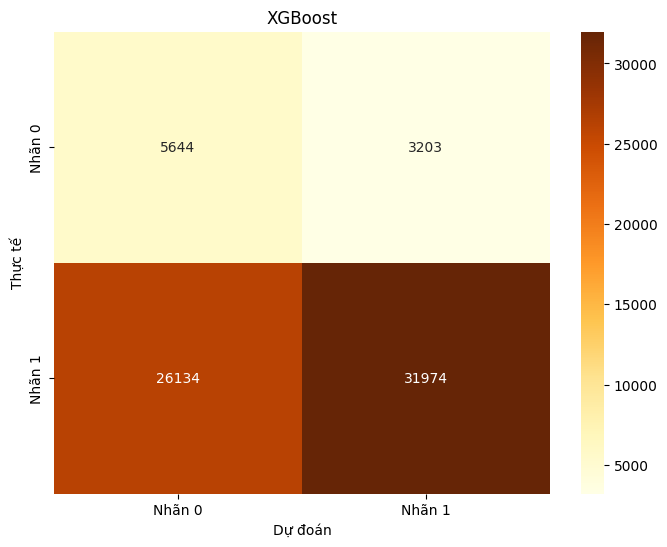

In [ ]:
# Ma trận nhầm lẫn
cm_gb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='YlOrBr', 
            xticklabels=['Nhãn 0', 'Nhãn 1'],
            yticklabels=['Nhãn 0', 'Nhãn 1'])
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title('XGBoost')
plt.show()

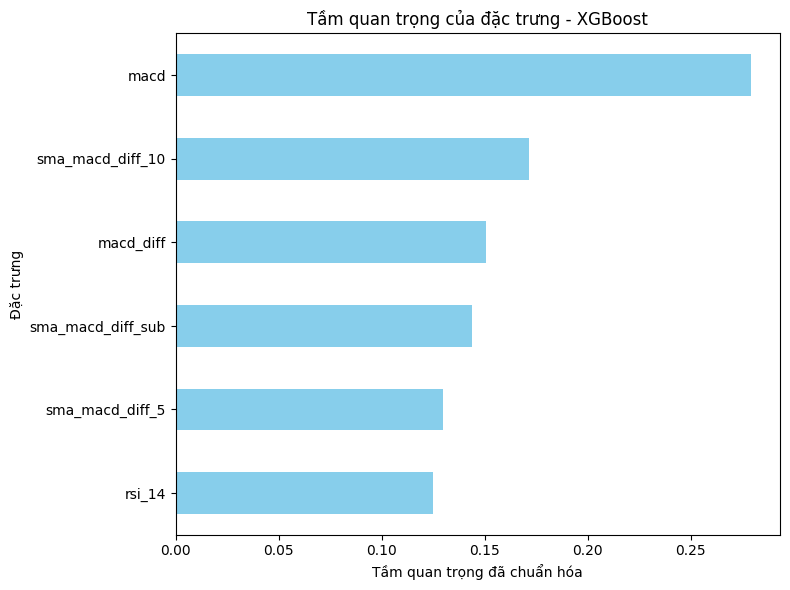

In [59]:

# Tính feature importance cho mô hình XGBoost
xgb_importance_raw = pd.Series(xgb_model.feature_importances_, index=features)
xgb_importance = xgb_importance_raw / xgb_importance_raw.sum()
xgb_importance = xgb_importance.sort_values()

# Vẽ biểu đồ riêng
plt.figure(figsize=(8, 6))
xgb_importance.plot(kind='barh', color='skyblue')
plt.title('Tầm quan trọng của đặc trưng - XGBoost')
plt.xlabel('Tầm quan trọng đã chuẩn hóa')
plt.ylabel('Đặc trưng')
plt.tight_layout()
plt.show()

In [ ]:
# Giả sử bạn đã huấn luyện rf_model xong trong ô trước đó

# Bước 1: Đọc file dữ liệu test mới
import pandas as pd
df_test = pd.read_csv('F:/dataML/data/TRX/TRX_2025-06-17_07-15-45.csv')

# Bước 2: Tách cột đầu ra (nếu có)
if Y_TYPE in df_test.columns:
    y_test_new = df_test[Y_TYPE]
    X_test_new = df_test.drop(columns=[Y_TYPE])
else:
    X_test_new = df_test
    y_test_new = None

# (Tùy chọn) Bảo đảm thứ tự và số cột giống X_train
X_test_new = X_test_new[xgb_model.feature_names_in_]

# Bước 3: Dự đoán
y_pred_new = xgb_model.predict(X_test_new)

# Bước 4: Đánh giá nếu có nhãn thật
if y_test_new is not None:
    from sklearn.metrics import classification_report
    print(classification_report(y_test_new, y_pred_new))
else:
    print("✅ Dự đoán hoàn tất, hiển thị kết quả:")
    print(y_pred_new[:10])


              precision    recall  f1-score   support

           0       0.28      0.03      0.05      1548
           1       0.67      0.97      0.79      3147

    accuracy                           0.66      4695
   macro avg       0.47      0.50      0.42      4695
weighted avg       0.54      0.66      0.55      4695



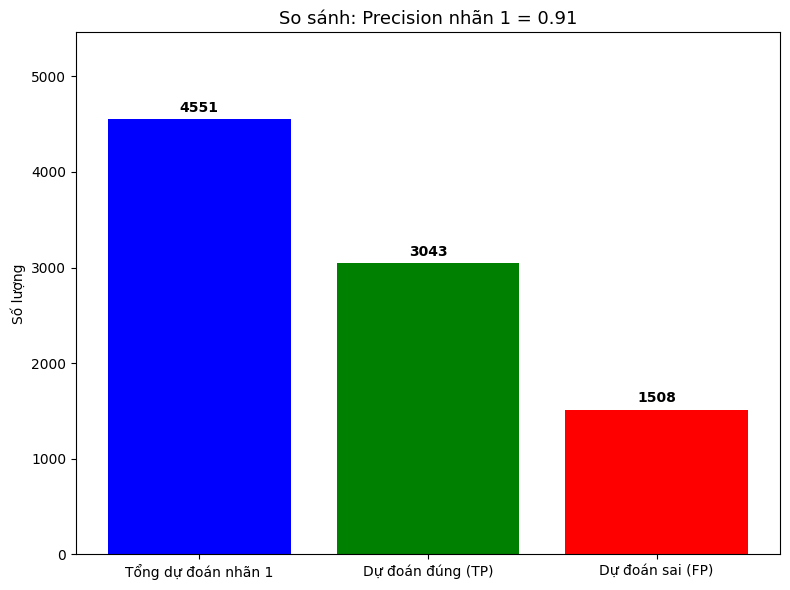

In [61]:
# Tính TP, FP cho nhãn 1
tp_1_new = np.sum((y_test_new == 1) & (y_pred_new == 1))  # True Positive
fp_1_new = np.sum((y_test_new == 0) & (y_pred_new == 1))  # False Positive
total_predicted_1_new = tp_1_new + fp_1_new  # Tổng số lần mô hình dự đoán là nhãn 1

# Precision cho nhãn 1
precision_1_new = tp_1_new / total_predicted_1_new if total_predicted_1_new > 0 else 0

# Dữ liệu biểu đồ
labels = ['Tổng dự đoán nhãn 1', 'Dự đoán đúng (TP)', 'Dự đoán sai (FP)']
values = [total_predicted_1_new, tp_1_new, fp_1_new]
colors = ['blue', 'green', 'red']

# Vẽ biểu đồ
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, values, color=colors)

# Thêm số liệu trên đầu cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50, f'{int(yval)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Tiêu đề biểu đồ
plt.title(f'So sánh: Precision nhãn 1 = {precision_1:.2f}', fontsize=13)
plt.ylabel('Số lượng')
plt.ylim(0, max(values) * 1.2)
plt.tight_layout()
plt.show()


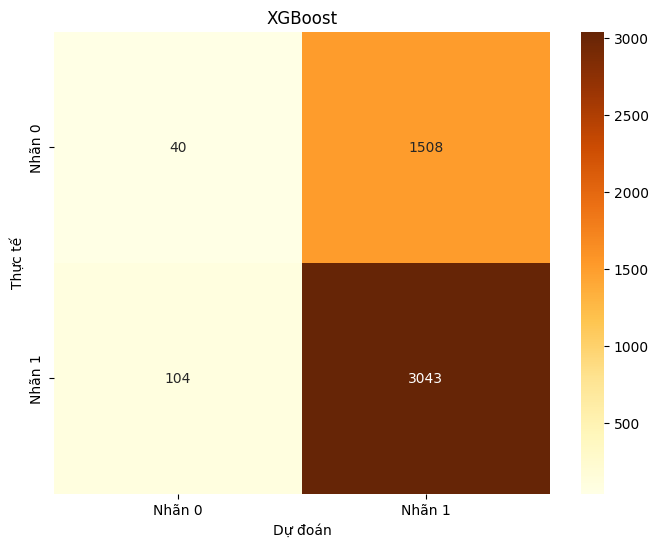

In [62]:
# Ma trận nhầm lẫn
cm_gb = confusion_matrix(y_test_new, y_pred_new)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='YlOrBr', 
            xticklabels=['Nhãn 0', 'Nhãn 1'],
            yticklabels=['Nhãn 0', 'Nhãn 1'])
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title('XGBoost')
plt.show()